In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# Functions

In [2]:
'''
Load the data from the file and return a dataframe with the 
date, average temperature, and average temperature uncertainty.
'''
def load_data(filepath):
    df = (pd.read_csv(filepath)
          .dropna() # Remove rows with missing values
          .iloc[1:, :] # First row has a temp. but skips the sequence; that far back not useful
          .reset_index(drop=True)
          .rename(columns={"dt": "date", 
                           "AverageTemperature": "avg_temp", 
                           "AverageTemperatureUncertainty": "avg_temp_uncertainty", # May be interesting to plot avg. temp +/- uncertainty
                           }
          )
    )
    
    df['date'] = pd.to_datetime(df['date'])

    cols_sel = ['date', 'avg_temp', 'avg_temp_uncertainty']
    
    return df.loc[:, cols_sel]

'''
This function takes a dataframe and a date range and 
returns a slice of the dataframe that falls within the date range.
'''
def get_slice(df_inp, start_date, end_date):

    slice = df_inp[(df_inp["date"] >= start_date) & (df["date"] <= end_date)]

    return slice

'''
This function takes a dataframe and a list of years and returns a list of slices of the dataframe.
Each slice is a 3-year period starting from the year
'''
def get_slice_list(years, df_inp):
    slice_list = []
    for year in years:
        slice = get_slice(df_inp, f"{year}-01-01", f"{year+2}-12-31")
        slice_list.append(slice)
    return slice_list

'''
Take a dataframe slice and size for training set and return the train and test sets.
Temporal so takes the first train_size rows as the training set and the rest as the test set.
'''
def train_test_split(df_slice_inp, train_size):
    train = (df_slice_inp.iloc[:train_size, :]["avg_temp"]
             .to_numpy()
             .reshape(-1, 1)
             )
    test = (df_slice_inp.iloc[train_size:, :]["avg_temp"]
            .to_numpy()
            .reshape(-1, 1)
    )

    return train, test

'''
Take a list of dataframe slices and a size for the training set and return the train and test sets.
X_train will be a 3D array with dimensions (num_slices, train_size, 1)
y_train will be a 3D array with dimensions (num_slices, (slice_size - train_size), 1)
'''
def train_test_split_batches(df_slice_lst, train_size):
    X_lst = []
    y_lst = []

    for df_slice in df_slice_lst:
        X, y = train_test_split(df_slice, train_size)
        X_lst.append(X)
        y_lst.append(y)

    X_train = np.array(X_lst)
    y_train = np.array(y_lst)

    return X_train, y_train

'''
Returns a dictionary for a simple RNN model with the following layers:
    - InputLayer
    - FullyConnectedLayer (FCLU, weights size D x K)
    - TanhLayer
    - FullyConnectedLayer (FCLW, weights size K x K) - for feedback 
    - FullyConnectedLayer (FCLV, weights size K x output_size) - for output
        * Must be reshaped to dimensions of labels to calculate errors
    - LinearLayer
    - SquaredError

'''
def make_RNN(X_inp, fcl_size, output_size, act_func="tanh"):

    from Layers.InputLayer import InputLayer
    from Layers.FullyConnectedLayer import FullyConnectedLayer
    from Layers.TanhLayer import TanhLayer
    from Layers.ReLULayer import ReLULayer
    from Layers.LinearLayer import LinearLayer
    from LossFunctions.SquaredError import SquaredError

    IL = InputLayer(X_inp)
    FCLU = FullyConnectedLayer(X_inp.shape[1], fcl_size, random=False, randstate=0)
    if act_func == "relu":
        ACT1 = ReLULayer()
    else:
        ACT1 = TanhLayer()

    FCLW = FullyConnectedLayer(fcl_size, fcl_size, random=False, randstate=1)
    FCLV = FullyConnectedLayer(fcl_size, output_size, random=False, randstate=2)
    ACT2 = LinearLayer()
    SE = SquaredError()

    model = {"IL": IL, "FCLU": FCLU, "ACT1": ACT1, "FCLW": FCLW, "FCLV": FCLV, "ACT2": ACT2, "SE": SE}

    return model

'''
Save the model to a pickle file.
Automatically puts in a subdirectory called "Models"
'''
def save_model_pickle(model, filename):
    import pickle

    with open(f"./Models/{filename}", "wb") as f:
        pickle.dump(model, f)

'''
Load the model from a pickle given filepath
'''
def load_model_pickle(filepath):
    import pickle

    with open(filepath, "rb") as f:
        model = pickle.load(f)

    return model

# Load and split data

In [3]:
df = load_data("./Data/PhiladelphiaLandTemperatures.csv")
years_train = [1980, 1983, 1990, 1993, 2000, 2003]

slices_train = get_slice_list(years_train, df)

X_train, y_train = train_test_split_batches(slices_train, 24)

# Train RNN - Tanh

## `train_RNN_inplace_with_batches_for()`

In [4]:
def train_RNN_inplace_with_batches_for(model, X, y, learning_rate, epochs):

    training_dict = {"epoch": list(range(epochs)),
                     "squared_error_avg": [],
                    #  "y_preds": [],
                     }

    for epoch in range(epochs):
        error_batches = []
        y_preds_batches = []

        for batch in range(len(X)):
            # reset model at start of batch, otherwise cycling over t will use the first t's output as the previous output
            model["FCLU"].reset()
            model["FCLW"].reset()
            model["FCLV"].reset()
            model["ACT1"].setPrevIn([])
            model["ACT1"].setPrevOut([])
            model["ACT2"].setPrevIn([])
            model["ACT2"].setPrevOut([])
            
            # Forward
            for t in range(len(X[batch])):
                IL_out = model["IL"].forward(X[batch][t])
                if t > 0:
                    FCLU_out = model["FCLU"].forward_with_feedback(IL_out, model["FCLW"].getPrevOut()[t-1])
                else:
                    FCLU_out = model["FCLU"].forward(IL_out)
                ACT1_out = model["ACT1"].forward(FCLU_out)
                FCLW_out = model["FCLW"].forward(ACT1_out)
                FCLV_out = model["FCLV"].forward(ACT1_out)
                ACT2_out = model["ACT2"].forward(FCLV_out)

            # Predictions and Loss
            y_preds_batch = ACT2_out
            y_preds_batches.append(y_preds_batch)
            # training_dict["y_preds"].append(ACT2_out)

            error_batch = model["SE"].eval(y, ACT2_out.reshape(y[batch].shape))
            # training_dict["squared_error"].append(error_batch)
            error_batches.append(error_batch)

            # Backward
            dhNext_dW = np.zeros((1, model["FCLV"].getWeights().shape[0])) # Same shape as what FCLV.backward(grad) is...
            
            for t in range(len(X[batch])-1, -1, -1):
                grad = model["SE"].gradient(y[batch], (model["ACT2"].getPrevOut()[-1].reshape(y[batch].shape))).reshape(1, -1)
                grad = model["ACT2"].backward(grad, t_inp=t)

                model["FCLV"].updateWeightsGradAccum(grad, t_inp=t)
                model["FCLV"].updateBiasesGradAccum(grad)

                grad = model["FCLV"].backward(grad) + dhNext_dW
                # if t == len(X)-1:
                    # print(f"FCLV gradient shape is: {grad.shape}") # Verify gradient shape
                grad = model["ACT1"].backward(grad, t_inp=t)

                if t > 0:
                    model["FCLW"].updateWeightsGradAccum(grad, t_inp=t-1) # Have to use t-1
                    model["FCLW"].updateBiasesGradAccum(grad)

                model["FCLU"].updateWeightsGradAccum(grad, t_inp=t)
                model["FCLU"].updateBiasesGradAccum(grad)

                dhNext_dW = model["FCLW"].backward(grad)

            # Update weights   
            model["FCLU"].updateWeights(grad, eta=learning_rate)
            model["FCLV"].updateWeights(grad, eta=learning_rate)
            model["FCLW"].updateWeights(grad, eta=learning_rate)
        training_dict["squared_error_avg"].append(np.mean(error_batches))

    return pd.DataFrame(training_dict)

## Error vs. Epochs

In [5]:
lr = 1e-5

# Assume scaling by X_train[0] is sufficient for all batches
rnn_tanh_batches = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0]) # Have to reinitialize
training_results_tanh_batches = train_RNN_inplace_with_batches_for(rnn_tanh_batches, X_train, y_train, learning_rate=lr, epochs=100)
training_results_tanh_batches

,epoch,squared_error_avg
0,0,229.148051
1,1,227.844055
2,2,226.547550
3,3,225.258493
4,4,223.976842
...,...,...
95,95,2.605340
96,96,2.555534
97,97,2.511318
98,98,2.472063


<AxesSubplot: xlabel='epoch'>

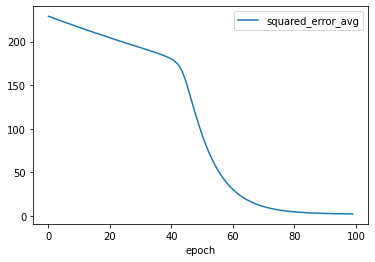

In [6]:
pd.DataFrame(training_results_tanh_batches).plot(x="epoch", y="squared_error_avg")

## "Optimal"": lr = 1e-5, epochs = 100

<AxesSubplot: xlabel='epoch'>

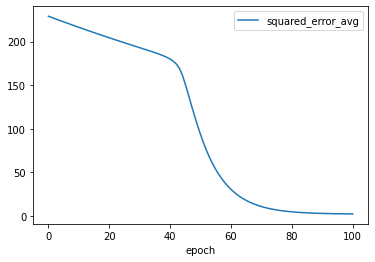

In [148]:
lr = 1e-5

# Assume scaling by X_train[0] is sufficient for all batches
rnn_tanh_batches = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0]) # Have to reinitialize
training_results_tanh_batches = train_RNN_inplace_with_batches_for(rnn_tanh_batches, X_train, y_train, learning_rate=lr, epochs=100+1)

pd.DataFrame(training_results_tanh_batches).plot(x="epoch", y="squared_error_avg")

In [103]:
pd.DataFrame(training_results_tanh_batches).tail(5)

,epoch,squared_error_avg
90,90,2.966258
91,91,2.875966
92,92,2.795801
93,93,2.724628
94,94,2.661439


# Plot Training predictions of batches, examine individual RMSEs

### `predict_batches()`

In [149]:
rnn_tanh_batches["FCLU"].getWeights()

array([[ 0.1500025 ,  0.16487814,  0.14551617, -0.16225805,  0.15288344,
         0.15313256,  0.16550683,  0.08586181, -0.15674192, -0.12945249,
         0.15370649, -0.08648424,  0.16394158, -0.15391621,  0.07593777,
        -0.13226425, -0.12078096, -0.11333958, -0.13245069, -0.11488037]])

In [150]:
def predict_batches(model, X_inp, y_inp):
    rmse_batches = []
    y_preds_batches = []

    for batch in range(len(X_inp)):
        model["FCLU"].reset()
        model["FCLW"].reset()
        model["FCLV"].reset()
        model["ACT1"].setPrevIn([])
        model["ACT1"].setPrevOut([])
        model["ACT2"].setPrevIn([])
        model["ACT2"].setPrevOut([])
        
        for t in range(len(X_inp[batch])):
            IL_out = model["IL"].forward(X_inp[batch][t])
            if t > 0:
                FCLU_out = model["FCLU"].forward_with_feedback(IL_out, model["FCLW"].getPrevOut()[t-1])
            else:
                FCLU_out = model["FCLU"].forward(IL_out)
            ACT1_out = model["ACT1"].forward(FCLU_out)
            FCLW_out = model["FCLW"].forward(ACT1_out)
            FCLV_out = model["FCLV"].forward(ACT1_out)
            ACT2_out = model["ACT2"].forward(FCLV_out)


        y_pred_batch = ACT2_out
        # print(y_pred_batch) # Print output
        y_preds_batches.append(y_pred_batch)

        error_batch = model["SE"].eval(y_inp[batch], y_pred_batch.reshape(y_inp[batch].shape))
        rmse_batch = np.sqrt(error_batch)
        rmse_batches.append(rmse_batch)

    return y_preds_batches, rmse_batches

In [181]:
y_preds_train_tanh, rmses_train_tanh = predict_batches(rnn_tanh_batches, X_train, y_train)

### Training predictions

RMSE for 1980 is: 1.84
RMSE for 1983 is: 1.43
RMSE for 1990 is: 1.23
RMSE for 1993 is: 1.54
RMSE for 2000 is: 1.51
RMSE for 2003 is: 1.19


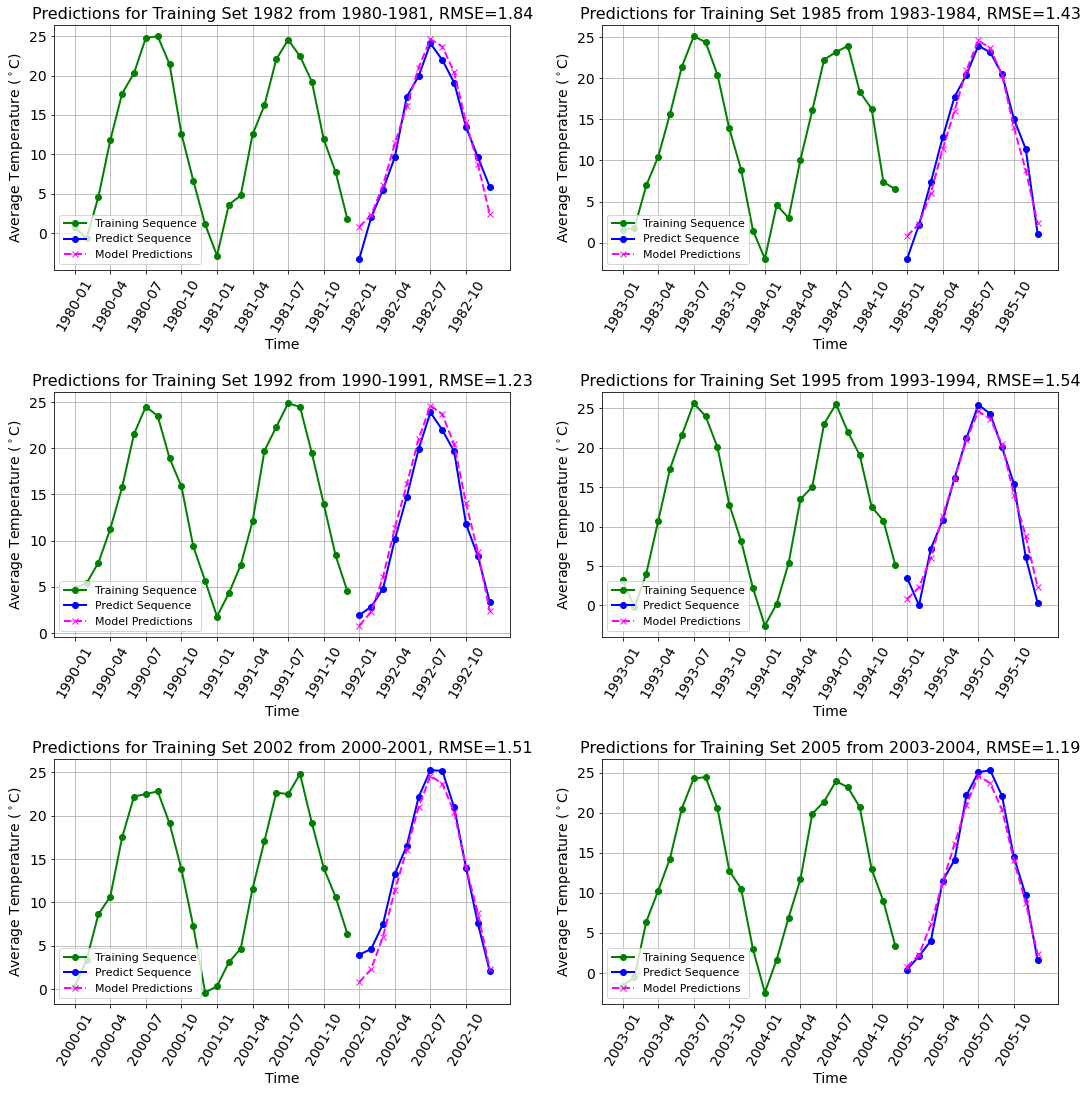

In [185]:
ax_coords = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

fig, axs = plt.subplots(3, 2, figsize=(18, 18), facecolor="white")
for i in range(len(years_train)):
    year = years_train[i]
    train_slice = slices_train[i]
    X_batch = X_train[i]
    y_batch = y_train[i]
    ax_coord = ax_coords[i]
    y_pred_batch = y_preds_train_tanh[i]
    rmse_batch = rmses_train_tanh[i]

    t_vals_x = train_slice.iloc[:len(X_batch), :]["date"].dt.strftime('%Y-%m')
    t_vals_y = train_slice.iloc[len(X_batch):(len(X_batch)+len(y_batch)), :]["date"].dt.strftime('%Y-%m')

    axs[ax_coord].plot(t_vals_x, X_batch.flatten(), color="green", linestyle="solid", label="Training Sequence", linewidth=2, marker="o")
    axs[ax_coord].plot(t_vals_y, y_batch.flatten(), color="blue", linestyle="solid", label="Predict Sequence", linewidth=2, marker="o")


    axs[ax_coord].plot(t_vals_y, y_pred_batch.flatten(), color = "magenta", linestyle="dashed", label=f"Model Predictions", linewidth=2, marker="x")


    axs[ax_coord].set_xlabel("Time", fontsize=14)
    axs[ax_coord].set_ylabel("Average Temperature ($^\circ$C)", fontsize=14)
    axs[ax_coord].set_title(f"Predictions for Training Set {year+2} from {year}-{year+1}, RMSE={rmse_batch:.2f}", 
                fontsize=16)
    new_xticks = (train_slice["date"].dt.strftime('%Y-%m')
                  .iloc[list(range(0, len(train_slice), 3))] # 3 month intervals
    )
    axs[ax_coord].set_xticks(new_xticks, labels=new_xticks.astype(str), rotation=60)
    # axs[ax_coord].set_xticks(new_xticks, rotation=45)
    # axs[ax_coord].set_xticklabels(new_xticks, rotation=45)
    axs[ax_coord].tick_params(axis="x", labelsize=14)
    axs[ax_coord].tick_params(axis="y", labelsize=14)
    axs[ax_coord].legend(fontsize=11, loc="lower left")
    axs[ax_coord].grid()

    # val_testing_dict["rmse"].append(rmse_batch)

    print(f"RMSE for {year} is: {rmse_batch:.2f}")
plt.subplots_adjust(hspace=0.5)

## Predictions similar across training batches...

In [43]:
y_preds_train

[array([[ 0.76460166,  2.18847443,  5.78882311, 10.87394389, 15.35027454,
         20.02538735, 23.50249976, 22.6055531 , 19.48402521, 13.40701769,
          8.38279634,  2.25866266]]),
 array([[ 0.76433056,  2.18770467,  5.78678813, 10.87011999, 15.34487869,
         20.01834552, 23.49423596, 22.5976036 , 19.47717383, 13.40230358,
          8.3798498 ,  2.25786993]]),
 array([[ 0.76444832,  2.18803905,  5.78767212, 10.87178109, 15.34722265,
         20.02140448, 23.49782574, 22.60105685, 19.48015006, 13.40435138,
          8.38112978,  2.2582143 ]]),
 array([[ 0.76440913,  2.1879278 ,  5.78737801, 10.87122843, 15.3464428 ,
         20.02038673, 23.49663139, 22.59990792, 19.47915984, 13.40367006,
          8.38070392,  2.25809973]]),
 array([[ 0.76433523,  2.18771796,  5.78682327, 10.87018601, 15.34497185,
         20.01846709, 23.49437863, 22.59774084, 19.47729212, 13.40238497,
          8.37990068,  2.25788362]]),
 array([[ 0.76451153,  2.18821852,  5.78814658, 10.87267263, 15.348480

### Save model

In [186]:
save_model_pickle(rnn_tanh_batches, "rnn_tanh_batches_6batches_100epochs.pkl")

In [187]:
load_model_pickle("./Models/rnn_tanh_batches_6batches_100epochs.pkl")

{'IL': <Layers.InputLayer.InputLayer at 0x7fd3a0d39160>,
 'FCLU': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7fd3a0db25e0>,
 'ACT1': <Layers.TanhLayer.TanhLayer at 0x7fd3a0d44f40>,
 'FCLW': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7fd3a0d44f10>,
 'FCLV': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7fd3a0d44fa0>,
 'ACT2': <Layers.LinearLayer.LinearLayer at 0x7fd3a0d441c0>,
 'SE': <LossFunctions.SquaredError.SquaredError at 0x7fd3a0d445b0>}

# Check validation

In [46]:
years_val = [1986, 1996, 2006,]

slices_val = get_slice_list(years_val, df)

X_val, y_val = train_test_split_batches(slices_val, 24)

In [47]:
y_preds_val, rmses_val = predict_batches(rnn_tanh_batches, X_val, y_val)
y_preds_val

[array([[ 0.76447463,  2.18811377,  5.78786966, 10.87215227, 15.34774642,
         20.02208803, 23.49862791, 22.60182851, 19.48081512, 13.40480898,
          8.3814158 ,  2.25829125]]),
 array([[ 0.76449718,  2.18817777,  5.78803884, 10.87247018, 15.34819501,
         20.02267346, 23.49931493, 22.6024894 , 19.48138472, 13.40520089,
          8.38166076,  2.25835715]]),
 array([[ 0.76450594,  2.18820265,  5.78810462, 10.87259379, 15.34836944,
         20.0229011 , 23.49958207, 22.60274638, 19.4816062 , 13.40535328,
          8.38175601,  2.25838278]])]

In [48]:
rmses_val

[1.5171501652215091, 2.134121020150092, 1.4281512122539706]

In [49]:
np.mean(rmses_val)

1.693140799208524

In [50]:
np.std(rmses_val)

0.31392979029668966

### Bar graph of non-train RMSEs

In [51]:
def all_val_slices(years_train_inp, df_inp):

    all_years_train = [year for year in years_train_inp]
    for year in years_train_inp:
        all_years_train.append(year+1)
        all_years_train.append(year+2)

    all_years_train = set(all_years_train)

    all_years = set(range(1983, 2012-1))
    val_years = all_years - all_years_train

    return get_slice_list(list(val_years), df_inp)

In [52]:
val_slices = all_val_slices(years_train, df)
pd.concat(val_slices)["date"].dt.year.unique()

array([1986, 1987, 1988, 1989, 1990, 1991, 1996, 1997, 1998, 1999, 2000,
       2001, 2006, 2007, 2008, 2009, 2010, 2011, 2012])

#### `get_df_val_RMSEs()`

In [53]:
def get_df_val_RMSEs(model, years_train):
    
    val_slices = all_val_slices(years_train, df)
    val_testing_dict = {"input_range": [], 
                        "predict_range": [], 
                        "rmse": []}
    for val_slice in val_slices:
        years_val_input = val_slice["date"].dt.year.unique()[:2]
        years_val_predict = val_slice["date"].dt.year.unique()[2:]
        val_testing_dict["input_range"].append(f"{years_val_input[0]}-{years_val_input[-1]}")
        val_testing_dict["predict_range"].append(f"{years_val_predict[0]}")
    
    X_val, y_val = train_test_split_batches(val_slices, 24)
    
    
    y_pred_val, rmse_val = predict_batches(model, X_val, y_val)
    val_testing_dict["rmse"] = rmse_val

    return pd.DataFrame(val_testing_dict)

In [153]:
df_val_RMSEs_tanh = get_df_val_RMSEs(rnn_tanh_batches, years_train)
df_val_RMSEs_tanh

,input_range,predict_range,rmse
0,1986-1987,1988,1.481412
1,1987-1988,1989,1.997983
2,1988-1989,1990,2.039611
3,1989-1990,1991,1.790916
4,1996-1997,1998,2.027694
5,1997-1998,1999,1.418633
6,1998-1999,2000,1.520829
7,1999-2000,2001,1.766276
8,2006-2007,2008,1.321535
9,2007-2008,2009,1.104023


#### `bar_graph_val_RMSEs()`

In [154]:
def bar_graph_val_RMSEs(df_val_RMSEs_inp):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

    avg_rmse = np.mean(df_val_RMSEs_inp["rmse"])
    stdev_rmse = np.std(df_val_RMSEs_inp["rmse"])
    ax.bar(df_val_RMSEs_inp["predict_range"], df_val_RMSEs_inp["rmse"])
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("RMSE ($^\circ$C)", fontsize=14)
    ax.set_title("Validation RMSEs of Average Monthly Temp. Predictions, RMSE$_{AVG}$ = " + f"{avg_rmse: .2f} +/- {stdev_rmse: .2f}", fontsize=16)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)

    plt.xticks(rotation=60)
    plt.show()

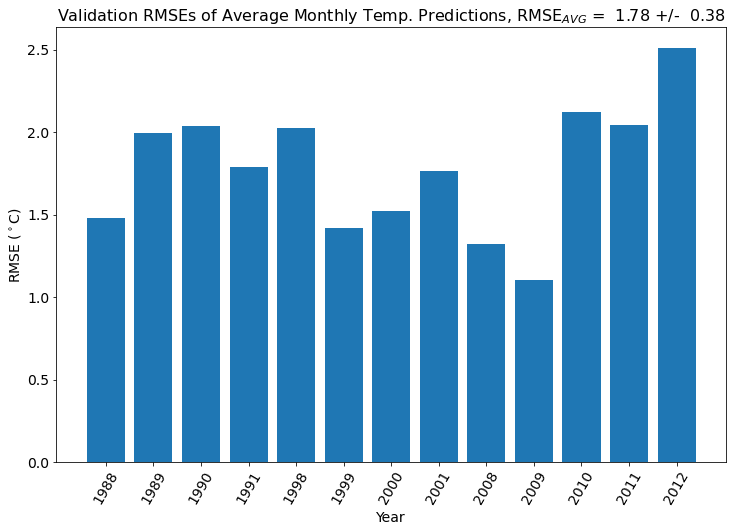

In [188]:
bar_graph_val_RMSEs(df_val_RMSEs_tanh)

# Train RNN with early stopping

In [107]:
lr = 1e-5

# Assume scaling by X_train[0] is sufficient for all batches
rnn_tanh_batches_early_stop = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0]) # Have to reinitialize
training_results_tanh_batches_early_stop = train_RNN_inplace_with_batches_for(rnn_tanh_batches_early_stop, X_train, y_train, learning_rate=lr, epochs=85+1)
training_results_tanh_batches_early_stop.tail(5)

,epoch,squared_error_avg
81,81,4.509185
82,82,4.245974
83,83,4.012247
84,84,3.804706
85,85,3.620420


## Predictions also the same for each input

In [108]:
y_preds_train_early_stop, rmses_train_early_stop = predict_batches(rnn_tanh_batches_early_stop, X_train, y_train)
y_preds_train_early_stop

[array([[ 0.73988537,  2.11509338,  5.59432728, 10.50909394, 14.83443691,
         19.35341697, 22.71363307, 21.84712146, 18.83019072, 12.95694916,
          8.10097355,  2.1823152 ]]),
 array([[ 0.73961475,  2.1143264 ,  5.59229985, 10.50528396, 14.82906111,
         19.34640079, 22.70539949, 21.83920086, 18.82336432, 12.95225232,
          8.09803803,  2.18152565]]),
 array([[ 0.73973198,  2.11465867,  5.59317818, 10.50693452, 14.83139001,
         19.34944033, 22.70896644, 21.84263222, 18.82632165, 12.95428708,
          8.09930976,  2.1818677 ]]),
 array([[ 0.73969272,  2.1145474 ,  5.59288405, 10.50638178, 14.83061012,
         19.34842246, 22.70777195, 21.84148313, 18.82533131, 12.95360569,
          8.09888389,  2.18175316]]),
 array([[ 0.73961913,  2.11433883,  5.59233272, 10.50534573, 14.82914827,
         19.34651455, 22.70553299, 21.83932928, 18.823475  , 12.95232848,
          8.09808563,  2.18153845]]),
 array([[ 0.73979506,  2.11483745,  5.59365078, 10.50782264, 14.832643

In [109]:
years_val = [1986, 1996, 2006,]

slices_val = get_slice_list(years_val, df)

X_val, y_val = train_test_split_batches(slices_train, 24)

y_preds_val, rmses_val = predict_batches(rnn_tanh_batches_early_stop, X_val, y_val)
y_preds_val

[array([[ 0.73988537,  2.11509338,  5.59432728, 10.50909394, 14.83443691,
         19.35341697, 22.71363307, 21.84712146, 18.83019072, 12.95694916,
          8.10097355,  2.1823152 ]]),
 array([[ 0.73961475,  2.1143264 ,  5.59229985, 10.50528396, 14.82906111,
         19.34640079, 22.70539949, 21.83920086, 18.82336432, 12.95225232,
          8.09803803,  2.18152565]]),
 array([[ 0.73973198,  2.11465867,  5.59317818, 10.50693452, 14.83139001,
         19.34944033, 22.70896644, 21.84263222, 18.82632165, 12.95428708,
          8.09930976,  2.1818677 ]]),
 array([[ 0.73969272,  2.1145474 ,  5.59288405, 10.50638178, 14.83061012,
         19.34842246, 22.70777195, 21.84148313, 18.82533131, 12.95360569,
          8.09888389,  2.18175316]]),
 array([[ 0.73961913,  2.11433883,  5.59233272, 10.50534573, 14.82914827,
         19.34651455, 22.70553299, 21.83932928, 18.823475  , 12.95232848,
          8.09808563,  2.18153845]]),
 array([[ 0.73979506,  2.11483745,  5.59365078, 10.50782264, 14.832643

In [110]:
df_val_RMSEs_tanh_early_stop = get_df_val_RMSEs(rnn_tanh_batches_early_stop, years_train)
df_val_RMSEs_tanh_early_stop

,input_range,predict_range,rmse
0,1986-1987,1988,1.699298
1,1987-1988,1989,2.210135
2,1988-1989,1990,2.341810
3,1989-1990,1991,2.282887
4,1996-1997,1998,2.435603
5,1997-1998,1999,1.934390
6,1998-1999,2000,1.719873
7,1999-2000,2001,2.097524
8,2006-2007,2008,1.750462
9,2007-2008,2009,1.462904


## Early stopping worse RMSE's overall

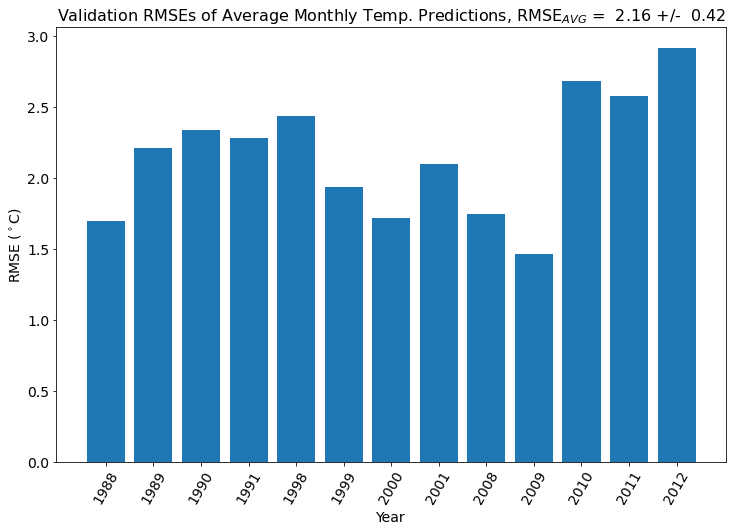

In [111]:
bar_graph_val_RMSEs(df_val_RMSEs_tanh_early_stop)

# Train ReLU Network

In [86]:
lr = 1e-6

# Assume scaling by X_train[0] is sufficient for all batches
rnn_relu_batches = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0], act_func="relu") # Have to reinitialize
training_results_relu_batches = train_RNN_inplace_with_batches_for(rnn_relu_batches, X_train, y_train, learning_rate=lr, epochs=800)
training_results_relu_batches

,epoch,squared_error_avg
0,0,229.630803
1,1,229.499815
2,2,229.368903
3,3,229.238066
4,4,229.107305
...,...,...
795,795,3.257506
796,796,3.254522
797,797,3.251558
798,798,3.248613


<AxesSubplot: xlabel='epoch'>

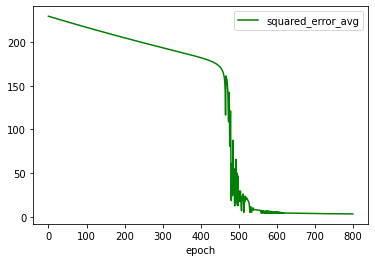

In [90]:
pd.DataFrame(training_results_relu_batches).plot(x="epoch", y="squared_error_avg", color="green")

## Compare errors of Tanh and ReLU

In [156]:
lr_tanh = 1e-5
lr_relu = 1e-6
num_epochs=800

# Assume scaling by X_train[0] is sufficient for all batches
rnn_tanh_batches = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0]) # Have to reinitialize
training_results_tanh_batches = train_RNN_inplace_with_batches_for(rnn_tanh_batches, X_train, y_train, learning_rate=lr_tanh, epochs=num_epochs)

rnn_relu_batches = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0], act_func="relu") # Have to reinitialize
training_results_relu_batches = train_RNN_inplace_with_batches_for(rnn_relu_batches, X_train, y_train, learning_rate=lr_relu, epochs=num_epochs)

df_error_vs_epochs_compare = pd.concat([pd.DataFrame(training_results_tanh_batches).assign(act_func="Tanh (Learning Rate = 1e-5)"),
                                        pd.DataFrame(training_results_relu_batches).assign(act_func="ReLU (Learning Rate = 1e-6)")], axis=0)

df_error_vs_epochs_compare

,epoch,squared_error_avg,act_func
0,0,229.148051,Tanh (Learning Rate = 1e-5)
1,1,227.844055,Tanh (Learning Rate = 1e-5)
2,2,226.547550,Tanh (Learning Rate = 1e-5)
3,3,225.258493,Tanh (Learning Rate = 1e-5)
4,4,223.976842,Tanh (Learning Rate = 1e-5)
...,...,...,...
795,795,3.257506,ReLU (Learning Rate = 1e-6)
796,796,3.254522,ReLU (Learning Rate = 1e-6)
797,797,3.251558,ReLU (Learning Rate = 1e-6)
798,798,3.248613,ReLU (Learning Rate = 1e-6)


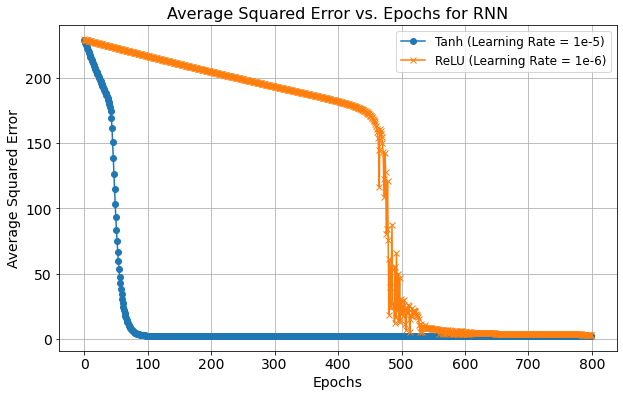

In [189]:
act_funcs = df_error_vs_epochs_compare['act_func'].unique()

fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

markers = ["o", "x"]

for act_func, marker in zip(act_funcs, markers):
    data = df_error_vs_epochs_compare[df_error_vs_epochs_compare['act_func'] == act_func]
    ax.plot(data['epoch'], data['squared_error_avg'], marker=marker, label=act_func)

# Format
ax.set_title('Average Squared Error vs. Epochs for RNN', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Average Squared Error', fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.grid()
ax.legend(fontsize=12)
plt.show()

## Optimal

<AxesSubplot: xlabel='epoch'>

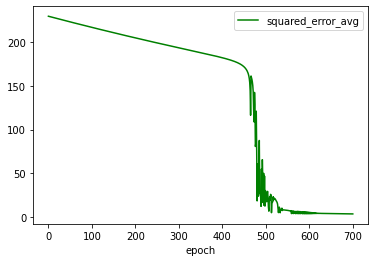

In [99]:
lr = 1e-5

# Assume scaling by X_train[0] is sufficient for all batches
rnn_relu_batches = make_RNN(X_inp = X_train[0], fcl_size=20, output_size=y_train[0].shape[0], act_func="relu") # Have to reinitialize
training_results_relu_batches = train_RNN_inplace_with_batches_for(rnn_relu_batches, X_train, y_train, learning_rate=lr_relu, epochs=700+1)

pd.DataFrame(training_results_relu_batches).plot(x="epoch", y="squared_error_avg", color="green")

In [179]:
y_preds_train_relu, rmses_train_relu = predict_batches(rnn_relu_batches, X_train, y_train)

RMSE for 1980 is: 1.75
RMSE for 1983 is: 1.69
RMSE for 1990 is: 0.82
RMSE for 1993 is: 1.73
RMSE for 2000 is: 1.91
RMSE for 2003 is: 1.57


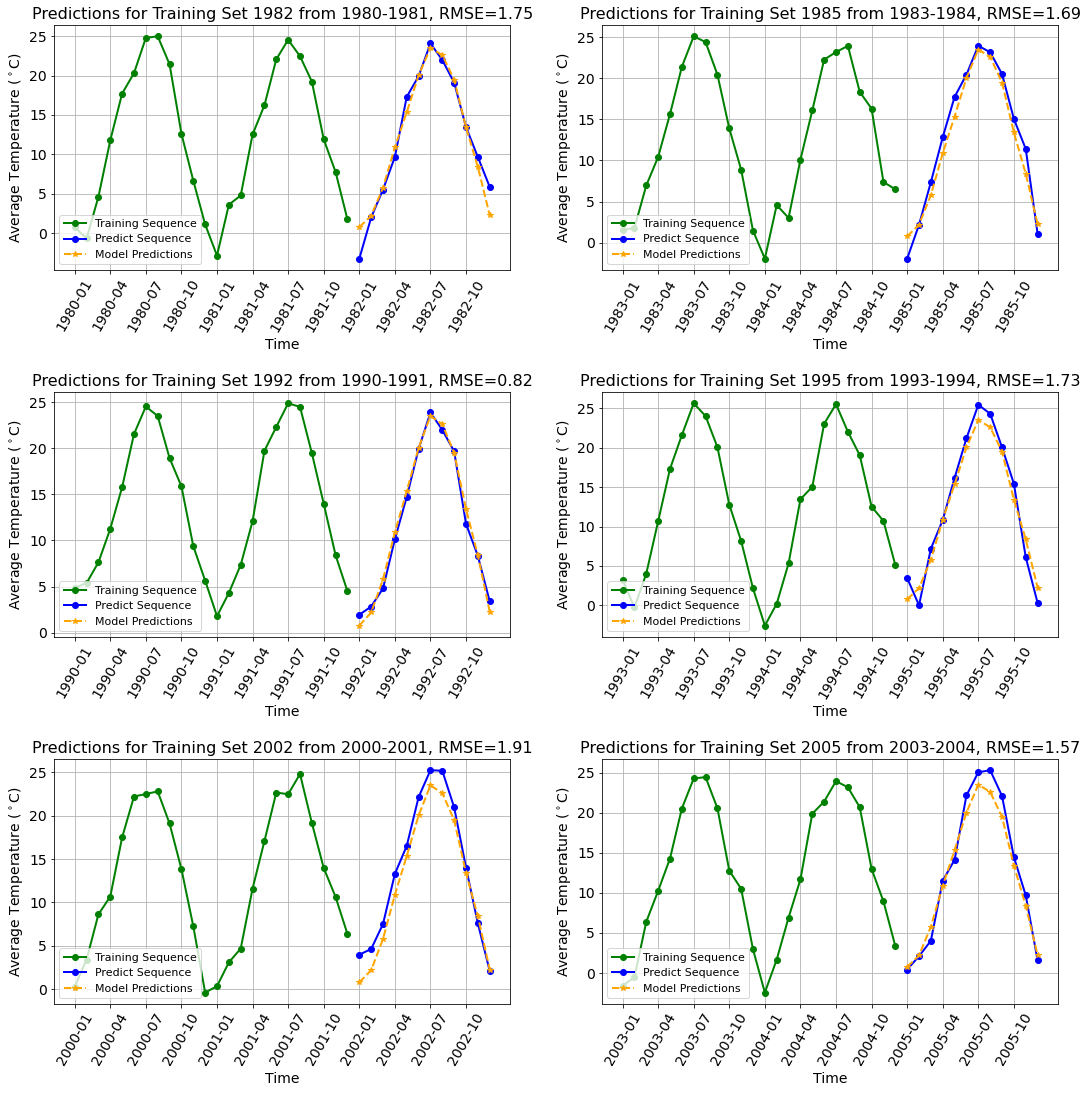

In [115]:
ax_coords = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

fig, axs = plt.subplots(3, 2, figsize=(18, 18), facecolor="white")
for i in range(len(years_train)):
    year = years_train[i]
    train_slice = slices_train[i]
    X_batch = X_train[i]
    y_batch = y_train[i]
    ax_coord = ax_coords[i]
    y_pred_batch = y_preds_train_relu[i]
    rmse_batch = rmses_train_relu[i]

    t_vals_x = train_slice.iloc[:len(X_batch), :]["date"].dt.strftime('%Y-%m')
    t_vals_y = train_slice.iloc[len(X_batch):(len(X_batch)+len(y_batch)), :]["date"].dt.strftime('%Y-%m')

    axs[ax_coord].plot(t_vals_x, X_batch.flatten(), color="green", linestyle="solid", label="Training Sequence", linewidth=2, marker="o")
    axs[ax_coord].plot(t_vals_y, y_batch.flatten(), color="blue", linestyle="solid", label="Predict Sequence", linewidth=2, marker="o")


    axs[ax_coord].plot(t_vals_y, y_pred_batch.flatten(), color = "orange", linestyle="dashed", label=f"Model Predictions", linewidth=2, marker="*")


    axs[ax_coord].set_xlabel("Time", fontsize=14)
    axs[ax_coord].set_ylabel("Average Temperature ($^\circ$C)", fontsize=14)
    axs[ax_coord].set_title(f"Predictions for Training Set {year+2} from {year}-{year+1}, RMSE={rmse_batch:.2f}", 
                fontsize=16)
    new_xticks = (train_slice["date"].dt.strftime('%Y-%m')
                  .iloc[list(range(0, len(train_slice), 3))] # 3 month intervals
    )
    axs[ax_coord].set_xticks(new_xticks, labels=new_xticks.astype(str), rotation=60)
    # axs[ax_coord].set_xticks(new_xticks, rotation=45)
    # axs[ax_coord].set_xticklabels(new_xticks, rotation=45)
    axs[ax_coord].tick_params(axis="x", labelsize=14)
    axs[ax_coord].tick_params(axis="y", labelsize=14)
    axs[ax_coord].legend(fontsize=11, loc="lower left")
    axs[ax_coord].grid()

    # val_testing_dict["rmse"].append(rmse_batch)

    print(f"RMSE for {year} is: {rmse_batch:.2f}")
plt.subplots_adjust(hspace=0.5)

## Compare Tanh and ReLU Training Prediction Plots

RMSE for 1980 is: 1.43
RMSE for 1983 is: 1.43
RMSE for 1990 is: 1.43
RMSE for 1993 is: 1.43
RMSE for 2000 is: 1.43
RMSE for 2003 is: 1.43


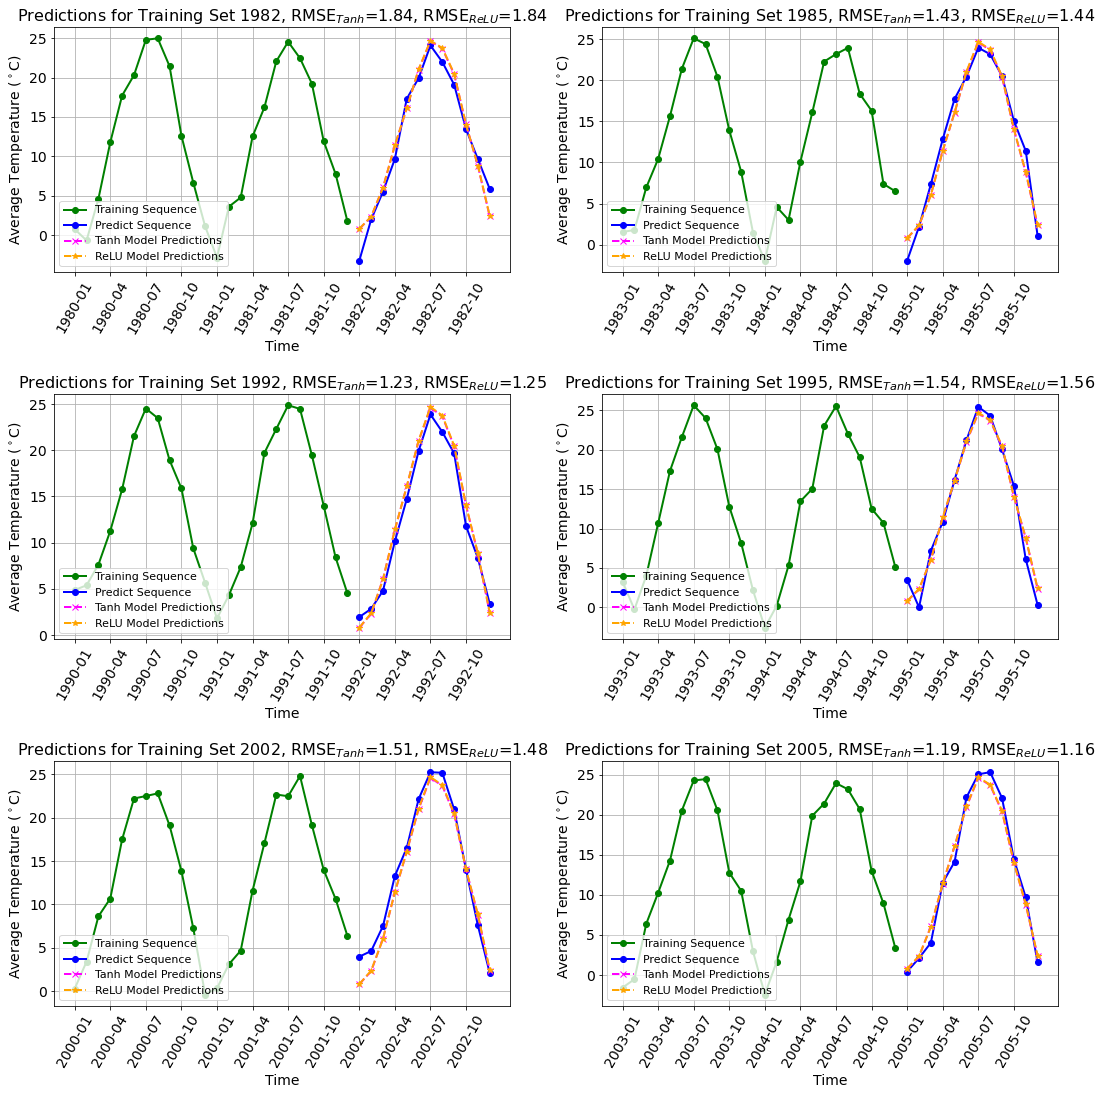

In [184]:
ax_coords = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

fig, axs = plt.subplots(3, 2, figsize=(18, 18), facecolor="white")
for i in range(len(years_train)):
    year = years_train[i]
    train_slice = slices_train[i]
    X_batch = X_train[i]
    y_batch = y_train[i]
    ax_coord = ax_coords[i]
    y_pred_batch_tanh = y_preds_train_tanh[i]
    rmse_batch_tanh = rmses_train_tanh[i]
    y_pred_batch_relu = y_preds_train_relu[i]
    rmse_batch_relu = rmses_train_relu[i]

    t_vals_x = train_slice.iloc[:len(X_batch), :]["date"].dt.strftime('%Y-%m')
    t_vals_y = train_slice.iloc[len(X_batch):(len(X_batch)+len(y_batch)), :]["date"].dt.strftime('%Y-%m')

    axs[ax_coord].plot(t_vals_x, X_batch.flatten(), color="green", linestyle="solid", label="Training Sequence", linewidth=2, marker="o")
    axs[ax_coord].plot(t_vals_y, y_batch.flatten(), color="blue", linestyle="solid", label="Predict Sequence", linewidth=2, marker="o")

    axs[ax_coord].plot(t_vals_y, y_pred_batch_tanh.flatten(), color = "magenta", linestyle="dashed", label=f"Tanh Model Predictions", linewidth=2, marker="x")
    axs[ax_coord].plot(t_vals_y, y_pred_batch_relu.flatten(), color = "orange", linestyle="dashed", label=f"ReLU Model Predictions", linewidth=2, marker="*")


    axs[ax_coord].set_xlabel("Time", fontsize=14)
    axs[ax_coord].set_ylabel("Average Temperature ($^\circ$C)", fontsize=14)
    axs[ax_coord].set_title(f"Predictions for Training Set {year+2}, RMSE$_{{Tanh}}$={rmse_batch_tanh:.2f}, RMSE$_{{ReLU}}$={rmse_batch_relu:.2f}", 
                fontsize=16)
    new_xticks = (train_slice["date"].dt.strftime('%Y-%m')
                  .iloc[list(range(0, len(train_slice), 3))] # 3 month intervals
    )
    axs[ax_coord].set_xticks(new_xticks, labels=new_xticks.astype(str), rotation=60)
    # axs[ax_coord].set_xticks(new_xticks, rotation=45)
    # axs[ax_coord].set_xticklabels(new_xticks, rotation=45)
    axs[ax_coord].tick_params(axis="x", labelsize=14)
    axs[ax_coord].tick_params(axis="y", labelsize=14)
    axs[ax_coord].legend(fontsize=11, loc="lower left")
    axs[ax_coord].grid()

    # val_testing_dict["rmse"].append(rmse_batch)

    print(f"RMSE for {year} is: {rmse_batch:.2f}")
plt.subplots_adjust(hspace=0.5)

## Check Validation

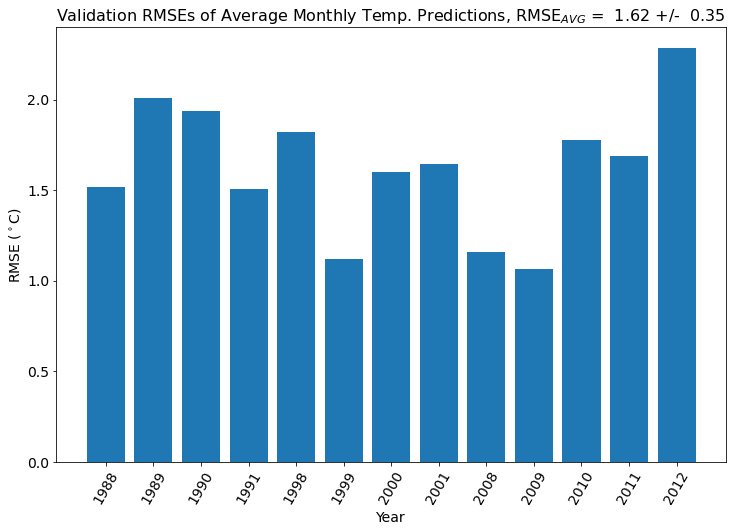

In [116]:
df_val_RMSEs_relu = get_df_val_RMSEs(rnn_relu_batches, years_train)
bar_graph_val_RMSEs(df_val_RMSEs_relu)

## Graph RMSE bar graphs comparing ReLU and Tanh

In [157]:
df_val_RMSEs_tanh["act_func"] = "Tanh"
df_val_RMSEs_relu["act_func"] = "ReLU"
df_val_RMSEs_compare = pd.concat([df_val_RMSEs_tanh, df_val_RMSEs_relu])
df_val_RMSEs_compare

,input_range,predict_range,rmse,act_func
0,1986-1987,1988,1.481412,Tanh
1,1987-1988,1989,1.997983,Tanh
2,1988-1989,1990,2.039611,Tanh
3,1989-1990,1991,1.790916,Tanh
4,1996-1997,1998,2.027694,Tanh
5,1997-1998,1999,1.418633,Tanh
6,1998-1999,2000,1.520829,Tanh
7,1999-2000,2001,1.766276,Tanh
8,2006-2007,2008,1.321535,Tanh
9,2007-2008,2009,1.104023,Tanh


In [131]:
def bar_graph_val_RMSEs_compare(df_val_RMSEs_inp):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

    avg_rmse = np.mean(df_val_RMSEs_inp["rmse"])
    stdev_rmse = np.std(df_val_RMSEs_inp["rmse"])

    for act_func in df_val_RMSEs_inp["act_func"].unique():
        df_act_func = df_val_RMSEs_inp[df_val_RMSEs_inp["act_func"] == act_func]
        ax.bar(df_act_func["predict_range"], df_act_func["rmse"], label=act_func)
    # ax.bar(df_val_RMSEs_inp["predict_range"], df_val_RMSEs_inp["rmse"])
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("RMSE ($^\circ$C)", fontsize=14)
    ax.set_title("Validation RMSEs of Average Monthly Temp. Predictions", fontsize=16)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.legend(fontsize=11)

    plt.xticks(rotation=60)
    plt.show()

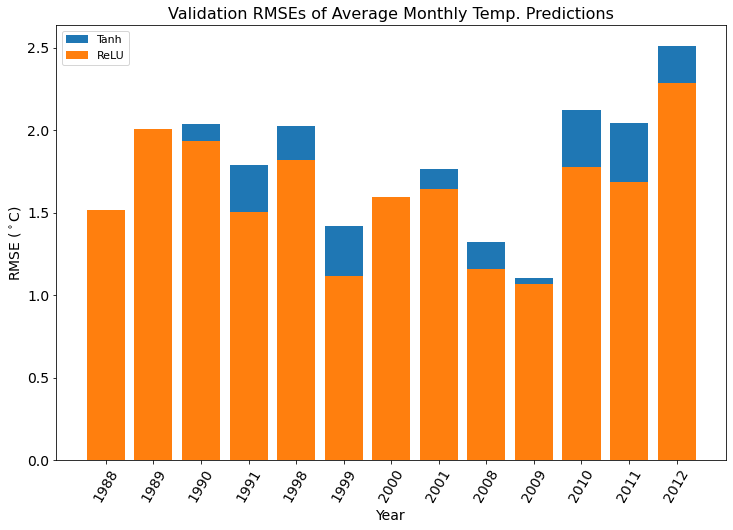

In [159]:
bar_graph_val_RMSEs_compare(df_val_RMSEs_compare)

### Side-by-side barplot easier with plotly.express

In [171]:
import plotly.express as px
fig = px.bar(df_val_RMSEs_compare,
       x="predict_range",
       y="rmse",
       color="act_func",
       template="simple_white",
       labels={"predict_range": "Year", "rmse": "RMSE (°C)", "act_func": "Activation Function"},
       barmode="group",
       title="RMSE of Predicted Monthly Average Temp. for Tanh and ReLU Activation Functions",
       width=800,
       height=400)

fig.update_layout(legend=dict(yanchor="top", xanchor="left", y=1.1, x=0.01))

### Barplot of average RMSE validation +/- stdev

In [177]:
rmse_avg_tanh = np.mean(df_val_RMSEs_tanh["rmse"])
rmse_avg_relu = np.mean(df_val_RMSEs_relu["rmse"])
rmse_stdev_tanh = np.std(df_val_RMSEs_tanh["rmse"])
rmse_stdev_relu = np.std(df_val_RMSEs_relu["rmse"])

rmse_dict = {"Activation Function": ["Tanh", "ReLU"],
             "Average RMSE": [rmse_avg_tanh, rmse_avg_relu],
             "Std. Dev. RMSE": [rmse_stdev_tanh, rmse_stdev_relu]}


df_rmse_avg_compare = pd.DataFrame(rmse_dict)

fig = px.bar(df_rmse_avg_compare,
       x="Activation Function",
       y="Average RMSE",
       color="Activation Function",
       template="simple_white",
       error_y="Std. Dev. RMSE",
       title="Average RMSE Comparison of RNN Activation Functions",
       labels={"Average RMSE": "Average RMSE (°C)",},
    #    barmode="group",
       width=600,
       height=400)


# fig.update_layout(legend=dict(yanchor="top", xanchor="left", y=1.2, x=0.01))
fig.show()

## Save model

In [112]:
save_model_pickle(rnn_relu_batches, "rnn_relu_batches_6batches_700e.pkl")

In [113]:
load_model_pickle("./Models/rnn_relu_batches_6batches_700e.pkl")

{'IL': <Layers.InputLayer.InputLayer at 0x7fd3d3e43a90>,
 'FCLU': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7fd3d227daf0>,
 'ACT1': <Layers.ReLULayer.ReLULayer at 0x7fd3d20bde80>,
 'FCLW': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7fd3d20bd190>,
 'FCLV': <Layers.FullyConnectedLayer.FullyConnectedLayer at 0x7fd3d20bddf0>,
 'ACT2': <Layers.LinearLayer.LinearLayer at 0x7fd3d20bd940>,
 'SE': <LossFunctions.SquaredError.SquaredError at 0x7fd3d20bde20>}